In [2]:
# 1. Import data.
# 2. Set up a small graph.
# 3. Train the model against it.
# 4. Save the model.
# 5. Restore and continue to train.

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
from os.path import exists
from os import makedirs

%matplotlib inline

In [51]:
# 1. Import data (it has already been scaled and centered).
full_image_size = 200
image_size  = 10
n_channels  = 1

def reformat(data): # Adds the channel dimension to the numpy arrays
    data = data.reshape( (-1, image_size, image_size, n_channels))  # -1 implies the dimension is inferred
    return data

def load_pickled_data(name):
    data   = pickle.load(open(name+'_dataset.p', 'rb'))
    labels = pickle.load(open(name+'_labels.p', 'rb'))
    return reformat(data), labels

data = {}; labels = {};

data['train'], labels['train'] = load_pickled_data('../data/train')
data['valid'], labels['valid'] = load_pickled_data('../data/valid')
data['test'], labels['test']   = load_pickled_data('../data/test')
data['test']   = data['test'][:full_image_size**2, :, :, :]
labels['test'] = labels['test'][:full_image_size**2, :]

In [52]:
# 2. Configure a simple 2-layer graph.

batch_size  = 64
n_classes   = 2
output_channels = [64, 128, 1024]
filter_size     = [3, 3]

# 10 x 10 input
# Convolve with 64 3 x 3 filters, stride 1 (out. image size of 10 x 10)
# Convolve with 128 3 x 3 filters, stride 2 (out. image size of 5 x 5)
# Fully connected layer (1024 nodes)
# Softmax output

simple_graph = tf.Graph()

with simple_graph.as_default():
    # Placeholders and constants
    tf_train_data   = tf.placeholder(tf.float32, [batch_size, image_size, image_size, n_channels]) # BWHN
    tf_train_labels = tf.placeholder(tf.float32, [batch_size, n_classes])
    tf_valid_data   = tf.constant(data['valid'])
    tf_test_data    = tf.constant(data['test'])
    
    # Variables
    filters1 = tf.Variable(tf.truncated_normal(
                    [filter_size[0], filter_size[0], n_channels, output_channels[0]], stddev = 0.01))
    biases1  = tf.Variable(tf.zeros([output_channels[0]]))
    
    filters2 = tf.Variable(tf.truncated_normal(
                    [filter_size[1], filter_size[1], output_channels[0], output_channels[1]], stddev = 0.01))
    biases2  = tf.Variable(tf.zeros([output_channels[1]]))
    
    weights3 = tf.Variable(tf.truncated_normal(
                    [output_channels[1] * image_size * image_size, n_classes], stddev = 0.01))
    biases3  = tf.Variable(tf.zeros(n_classes))
    
    def model(data):
        # Layer 1 : 20 x 20 x 1 input ; 10 x 10 x 64 output ; (3 x 3 x 1) x 64 filters ; stride of 2 ; same padding
        conv = tf.nn.conv2d(data, filters1, strides = [1, 1, 1, 1], padding = 'SAME', use_cudnn_on_gpu = True)
        act  = tf.nn.relu(conv + biases1)
        
        # Layer 2 : 10 x 10 x 64 input ; 5 x 5 x 128 output ; (3 x 3 x 64) x 128 filters ; stride of 2 ; same padding
        conv = tf.nn.conv2d(act, filters2, strides = [1, 1, 1, 1], padding = 'SAME', use_cudnn_on_gpu = True)
        act  = tf.nn.relu(conv + biases2)
        
        # layer 3 : fully connected ; 5*5*128 input ; (5*5*128 x 2) filters
        shape  = act.get_shape().as_list()
        act    = tf.reshape(act, [shape[0], shape[1]*shape[2]*shape[3]])
        logits = tf.nn.relu(tf.matmul(act, weights3) + biases3)
        return logits
    
    # Loss and optimizer
    logits = model(tf_train_data)
    loss   = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels))
    optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
    
    # Feedback information
    tf_train_predictions = tf.nn.softmax(logits)
    tf_valid_predictions = tf.nn.softmax(model(tf_valid_data))
    tf_test_predictions  = tf.nn.softmax(model(tf_test_data))
    
    # Saver
    saver = tf.train.Saver()

In [67]:
# 3. Create and run a session.

def accuracy_score(pred, true):
    return 100*np.sum(np.equal(np.argmax(pred, axis = 1), np.argmax(true, axis = 1)))/pred.shape[0]

def minibatch(data, labels, batch_size, step):
    posn         = (step * batch_size) % (data.shape[0] - batch_size)
    batch_data   = data[posn:(posn + batch_size), :, :, :]
    batch_labels = labels[posn:(posn + batch_size), :]
    return batch_data, batch_labels

def performance_report(step, loss, train_predictions, train_labels):
    print('Step {}\n------------'.format(step))
    print('Minibatch loss: {:06.2f}\n'.format(loss))
    print('Minibatch accuracy: {:04.2f}%\n'.format(accuracy_score(train_predictions, train_labels)))
    print('Validation accuracy: {:04.2f}%\n\n'.format(accuracy_score(tf_valid_predictions.eval(), labels['valid'])))


n_steps = 10001

with tf.Session(graph = simple_graph) as session:
    if not exists('./tmp/'): makedirs('./tmp/')
    if exists('./tmp/model.ckpt.index'):
        saver.restore(session, './tmp/model.ckpt')
    else:
        tf.global_variables_initializer().run()
        print('Session initialized. Training...')
    
    for step in range(n_steps):
        batch_data, batch_labels = minibatch(data['train'], labels['train'], batch_size, step)
        fd = {tf_train_data:batch_data, tf_train_labels:batch_labels}
        
        _, l, batch_predictions  = session.run([optimizer, loss, tf_train_predictions], feed_dict = fd)
        
        if step % 2000 == 0:
            performance_report(step, l, batch_predictions, batch_labels)
            
    saver.save(session, './tmp/model.ckpt')
    print('Testing accuracy @ {} steps: {:04.2f}%'.format(n_steps,
                                                          accuracy_score(tf_test_predictions.eval(), labels['test'])))
    test_predictions = tf_test_predictions.eval()

INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt
Step 0
------------
Minibatch loss: 000.51

Minibatch accuracy: 70.31%

Validation accuracy: 83.91%


Step 2000
------------
Minibatch loss: 000.17

Minibatch accuracy: 96.88%

Validation accuracy: 77.48%


Step 4000
------------
Minibatch loss: 000.08

Minibatch accuracy: 100.00%

Validation accuracy: 79.36%


Step 6000
------------
Minibatch loss: 000.16

Minibatch accuracy: 95.31%

Validation accuracy: 80.43%


Step 8000
------------
Minibatch loss: 000.18

Minibatch accuracy: 93.75%

Validation accuracy: 82.31%


Step 10000
------------
Minibatch loss: 000.16

Minibatch accuracy: 93.75%

Validation accuracy: 84.45%


Testing accuracy @ 10001 steps: 99.63%


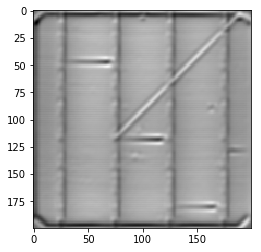

In [72]:
plt.imshow(test_predictions[:, 1].reshape([full_image_size, full_image_size]), cmap = 'gray')